In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy

In [2]:
import numpy as np
import pandas as pd

In [80]:
lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")

In [96]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']

In [5]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-06-18-19h00.csv", sep=";")
data.head()

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0


In [6]:
days = data[data['reg']==11][data['cl_age90']==0].jour.values
hosp_real = data[data['reg']==11][data['cl_age90']==0].hosp.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from group import SEIR_group, DynamicalModel
from heuristics import *
from fast_group import FastDynamicalModel
from aux import *


In [8]:
region = "Ile-de-France"

In [9]:
# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    initialization = yaml.load(file, Loader=yaml.FullLoader)
    

In [10]:
initialization["age_group_40_49"]["I"] = initialization["age_group_40_49"]["I"] + 1
initialization["age_group_40_49"]["S"] = initialization["age_group_40_49"]["S"] - 1
for group in age_groups:
    initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]

cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
       'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [11]:
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-02", '%Y-%m-%d')
date_4 = datetime.strptime("2020-06-15", '%Y-%m-%d')
date_5 = datetime.strptime("2020-06-22", '%Y-%m-%d')
#final_date = datetime.strptime(days[-1], '%Y-%m-%d') + timedelta(days=1)
final_date = datetime.strptime("2020-06-24", '%Y-%m-%d')

In [12]:
from copy import deepcopy

In [13]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, 1.0, mixing_method)
initial_state = state_to_matrix(initialization)

original_mu = deepcopy(dynModel.mu)
original_sigma = deepcopy(dynModel.sigma)
original_p_H = deepcopy(dynModel.p_H)
original_lambda_H_R = deepcopy(dynModel.lambda_H_R)
original_lambda_H_D = deepcopy(dynModel.lambda_H_D)


In [14]:
# Calculate windows
p_H_window = (np.mean(lower_data['p_H']/original_p_H),np.mean(upper_data['p_H']/original_p_H))
lambda_H_R_window = (2*np.mean(lower_data['lambda_HR']/original_lambda_H_R)-1,2*np.mean(upper_data['lambda_HR']/original_lambda_H_R)-1)
lambda_H_D_window = (np.mean(lower_data['lambda_HD']/original_lambda_H_D),np.mean(upper_data['lambda_HD']/original_lambda_H_D))
mu_window = (0.7,1.3)
sigma_window = (0.7,1.3)
beta_window = (0.7,1.3)
print(p_H_window)
print(lambda_H_R_window)
print(lambda_H_D_window)


(0.29426002214278124, 1.8212173013636006)
(0.9133837542743426, 1.082504501907461)
(0.7625396172625034, 1.4161159941770656)


In [15]:
vf = [64.93486491,  0.58029402,  1.1908528,   1.28166241,
      0.60343286,  0.91659416, 0.79972529,  0.69355068,  0.94716531,  0.16887425,  
      0.72599347,  0.7820672, 0.29664569,  1.06938925,  0.94869935]

In [29]:
best_v = 0
best_error = float('inf')
def error(v):
    days_ahead = v[0]
    alpha = v[1]
    beta = v[2]
    gamma = v[3]
    
    delta_transport = v[4]
    delta_leisure = v[5]
    delta_other = v[6]
    delta_work = v[7]
    delta_school = v[8]
    delta_lockdown = v[9]
    
    dynModel.mu = v[10]*original_mu
    dynModel.sigma = v[11]*original_sigma
    dynModel.p_H = v[12]*original_p_H
    dynModel.lambda_H_R = v[13]*original_lambda_H_R
    dynModel.lambda_H_D = v[14]*original_lambda_H_D

    # Alphas
    a_before_date_1 = {
        'home':1.0,
        'leisure':1.0,
        'other':1.0,
        'school':1.0,
        'transport':1.0,
        'work':1.0
    }
    a_between_date_1_2 = {
        'home':1.0,
        'leisure':delta_lockdown,
        'other':delta_lockdown,
        'school':0,
        'transport':0.24*delta_transport,
        'work':0.24
    }
    a_between_date_2_3 = {
        'home':1.0,
        'leisure':0.25*delta_leisure,
        'other':delta_other,
        'school':0.33*delta_school,
        'transport':delta_transport*delta_work,
        'work':delta_work
    }
    a_between_date_3_4 = {
        'home':1.0,
        'leisure':0.5*delta_leisure,
        'other':delta_other,
        'school':0.67*delta_school,
        'transport':delta_transport*delta_work,
        'work':delta_work
    }
    a_between_date_4_5 = {
        'home':1.0,
        'leisure':0.75*delta_leisure,
        'other':delta_other,
        'school':0.67*delta_school,
        'transport':delta_transport*delta_work,
        'work':delta_work
    }
    a_after_date_5 = {
        'home':1.0,
        'leisure':1.0*delta_leisure,
        'other':delta_other,
        'school':1.0*delta_school,
        'transport':delta_transport*delta_work,
        'work':delta_work
    }


    # Determine mixing method
    mixing_method = {
        "name":"mult",
        "param_alpha":alpha,
        "param_beta":beta,
        "param_gamma":gamma,
    }
    dynModel.mixing_method = mixing_method

    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_date_1
        alphas_vec.append(alphas)
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_1_2
        alphas_vec.append(alphas)
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_2_3
        alphas_vec.append(alphas)
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_3_4
        alphas_vec.append(alphas)
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_4_5
        alphas_vec.append(alphas)
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_after_date_5
        alphas_vec.append(alphas)

    # Calculate tests
    tests = np.zeros(len(age_groups))
    
    
    # Run model
    model_data = []
    state = initial_state
    model_data.append(np.sum(state[:,cont.index("H")]))
    
    for t in range(total_days):
        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
        model_data.append(np.sum(state[:,cont.index("H")]))
            
    
    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data = [float('nan')]*len(days_model)
    for k,ind in enumerate(indices):
        real_data[ind] = hosp_real[k]

    error = np.nanmean(np.abs(np.log(np.array(model_data)/np.array(real_data))))
    error = np.nanmean(np.abs(np.array(model_data)-np.array(real_data)))
    global best_error
    if error<best_error:
        best_error = error
        print(best_error)
        best_v = v
        print(v)
    return error





In [30]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution
epsilon = 0.1
result = differential_evolution(error, [(60,120),(0.1,3.0),(0.1,3.0),beta_window,
                                        (0,1.0),(0.5,1.0),(0.5,1.0),(0.5,1.0),(0.5,1.0),(0.0,0.25),
                                        mu_window, sigma_window, p_H_window, lambda_H_R_window, lambda_H_D_window])




23969.34609770942
[102.4049847    0.90036794   1.65890605   0.86925991   0.41150906
   0.85417676   0.94083759   0.73654693   0.61904871   0.23748689
   0.73709685   0.79541292   1.20821346   0.95612411   0.95830961]
8303.633514612016
[6.07648589e+01 3.79058450e-01 2.42252829e+00 7.06135757e-01
 7.68928522e-01 9.39752910e-01 7.29142727e-01 9.11670107e-01
 5.22465143e-01 3.65690181e-02 1.18177330e+00 1.24118720e+00
 1.03675098e+00 9.21475056e-01 1.01543482e+00]
8290.570253814787
[118.7278109    1.0699802    2.00888342   1.22136432   0.57774523
   0.81739039   0.82125094   0.57709142   0.78351397   0.17321632
   0.96589019   1.20790074   1.39157689   0.98004396   1.37414519]
7530.919579508732
[70.48753451  1.73299834  1.90790493  0.81020119  0.93230341  0.60774688
  0.50157548  0.62199641  0.77527819  0.18880822  0.75411702  0.9079373
  1.21366877  1.06879898  1.1013335 ]
6647.407983298757
[8.02238800e+01 6.03949486e-01 1.96880944e+00 1.03380024e+00
 8.59419307e-01 5.32255845e-01 7.92915

KeyboardInterrupt: 

In [31]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution

v0 = [65.82385115,  1.86193535,  0.82940781,  1.25526659,  0.37720601,  0.78727721,
  0.76134451,  0.75161425,  0.73168703,  0.08529552,  0.71404452,  0.79096004,
  0.30669664,  0.91468578,  0.90263896]
bounds = Bounds([60,0.1,0.1,beta_window[0],   0,0.5,0.5,0.5,0.5,0.0,   mu_window[0],sigma_window[0],p_H_window[0],lambda_H_R_window[0],lambda_H_D_window[0]], 
                [120,3.0,3.0,beta_window[1],  1,1.0,1.0,1.0,1.0,0.25,   mu_window[1],sigma_window[1],p_H_window[1],lambda_H_R_window[1],lambda_H_D_window[1]])

result = minimize(error, v0, bounds = bounds)

497.9976986220661
[65.82385115  1.86193535  0.82940781  1.25526659  0.37720601  0.78727721
  0.76134451  0.75161425  0.73168703  0.08529552  0.71404452  0.79096004
  0.30669664  0.91468578  0.90263896]
497.99769789212286
[65.82385115  1.86193536  0.82940781  1.25526659  0.37720601  0.78727721
  0.76134451  0.75161425  0.73168703  0.08529552  0.71404452  0.79096004
  0.30669664  0.91468578  0.90263896]
497.9976369429714
[65.82385115  1.86193535  0.82940781  1.2552666   0.37720601  0.78727721
  0.76134451  0.75161425  0.73168703  0.08529552  0.71404452  0.79096004
  0.30669664  0.91468578  0.90263896]
496.9980391680759
[65.82385115  1.86261941  0.8307125   1.25529348  0.37697928  0.78710454
  0.76118742  0.75146301  0.73154777  0.08539452  0.71403608  0.79126601
  0.30668916  0.91478665  0.9029476 ]
496.9980388748627
[65.82385115  1.86261942  0.8307125   1.25529348  0.37697928  0.78710454
  0.76118742  0.75146301  0.73154777  0.08539452  0.71403608  0.79126601
  0.30668916  0.91478665  0

496.87150726769147
[65.82385115  1.86299265  0.83142191  1.25525133  0.37685646  0.78701076
  0.7610845   0.75136802  0.73147224  0.08544693  0.71408743  0.79139983
  0.30661455  0.91484846  0.90311612]
496.87150027097294
[65.82385115  1.86299279  0.83142218  1.25525129  0.37685642  0.78701072
  0.76108448  0.75136799  0.73147221  0.08544695  0.71408751  0.79139992
  0.30661459  0.91484849  0.90311619]
496.8715001412947
[65.82385115  1.8629928   0.83142218  1.25525129  0.37685642  0.78701072
  0.76108448  0.75136799  0.73147221  0.08544695  0.71408751  0.79139992
  0.30661459  0.91484849  0.90311619]
496.8714933322008
[65.82385115  1.86299279  0.83142218  1.25525129  0.37685642  0.78701072
  0.76108448  0.75136799  0.73147221  0.08544695  0.71408752  0.79139992
  0.30661459  0.91484849  0.90311619]
496.87148966705456
[65.82385115  1.8629929   0.83142238  1.25525126  0.37685639  0.7870107
  0.76108446  0.75136797  0.73147219  0.08544696  0.71408758  0.79139998
  0.30661463  0.91484851  

In [46]:
vf = [64.93486491,  0.58029402,  1.1908528,   1.28166241,
      0.60343286,  0.91659416, 0.79972529,  0.69355068,  0.94716531,  0.16887425,  
      0.72599347,  0.7820672, 0.29664569,  1.06938925,  0.94869935]

vf = [65.82385115,  1.86299295,  0.83142249,  1.25525124,  0.37685637,  0.78701069,
  0.76108445,  0.75136796,  0.73147218,  0.08544696,  0.71408762,  0.79140002,
  0.30661464,  0.91484853,  0.90311626]

In [47]:
error(vf)

TypeError: 'numpy.float64' object is not callable

In [63]:
days_ahead = vf[0]
alpha = vf[1]
beta = vf[2]
gamma = vf[3]

delta_transport = vf[4]
delta_leisure = vf[5]
delta_other = vf[6]
delta_work = vf[7]
delta_school = vf[8]
delta_lockdown = vf[9]

dynModel.mu = vf[10]*original_mu
dynModel.sigma = vf[11]*original_sigma
dynModel.p_H = vf[12]*original_p_H
dynModel.lambda_H_R = vf[13]*original_lambda_H_R
dynModel.lambda_H_D = vf[14]*original_lambda_H_D


# Alphas
a_before_date_1 = {
    'home':1.0,
    'leisure':1.0,
    'other':1.0,
    'school':1.0,
    'transport':1.0,
    'work':1.0
}
a_between_date_1_2 = {
    'home':1.0,
    'leisure':delta_lockdown,
    'other':delta_lockdown,
    'school':0,
    'transport':0.24*delta_transport,
    'work':0.24
}
a_between_date_2_3 = {
    'home':1.0,
    'leisure':0.25*delta_leisure,
    'other':delta_other,
    'school':0.33*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_between_date_3_4 = {
    'home':1.0,
    'leisure':0.5*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_between_date_4_5 = {
    'home':1.0,
    'leisure':0.75*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_after_date_5 = {
    'home':1.0,
    'leisure':1.0*delta_leisure,
    'other':delta_other,
    'school':1.0*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}


# Determine mixing method
mixing_method = {
    "name":"mult",
    "param_alpha":alpha,
    "param_beta":beta,
    "param_gamma":gamma
}
dynModel.mixing_method = mixing_method

# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_between_dates_4_5 = (date_5-date_4).days
days_after_date_5 = (final_date-date_5).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_date_1
    alphas_vec.append(alphas)
for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_1_2
    alphas_vec.append(alphas)
for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_2_3
    alphas_vec.append(alphas)
for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_3_4
    alphas_vec.append(alphas)
for t in range(days_between_dates_4_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_4_5
    alphas_vec.append(alphas)
for t in range(days_after_date_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_after_date_5
    alphas_vec.append(alphas)

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data = []
state = initial_state
model_data.append(np.sum(state[:,cont.index("H")]))

for t in range(total_days):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    model_data.append(np.sum(state[:,cont.index("H")]))


initial_date = date_1-timedelta(days=days_before_date_1)

# Calculate the days of the model
days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

# Indices where to put the real data
indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

# Real data
real_data = [float('nan')]*len(days_model)
for k,ind in enumerate(indices):
    real_data[ind] = hosp_real[k]
error = np.nanmean(np.abs(np.log(np.array(model_data)/np.array(real_data))))

print(error)

0.08604962783603615


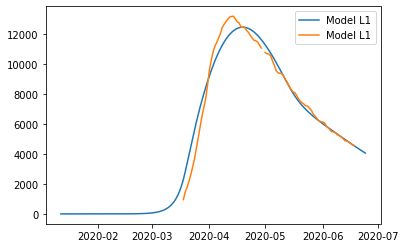

In [59]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data, label="Model L1")
plt.plot(days_model, real_data, label="Model L1")
plt.legend(loc='upper right')

In [64]:
with open("../initialization/initialization.yaml") as file:
    initialization = yaml.load(file, Loader=yaml.FullLoader)
with open("../parameters/Ile-de-France.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)


In [81]:
# Modify parameters
universe_params['mixing'] = {
    "name":"mult",
    "param_alpha":alpha,
    "param_beta":beta,
}
for age_group in age_groups:
    universe_params['seir-groups'][age_group]['parameters']['beta'] = universe_params['seir-groups'][age_group]['parameters']['beta']*vf[2]
    universe_params['seir-groups'][age_group]['parameters']['mu'] = universe_params['seir-groups'][age_group]['parameters']['mu']*vf[10]
    universe_params['seir-groups'][age_group]['parameters']['sigma'] = universe_params['seir-groups'][age_group]['parameters']['sigma']*vf[11]
    universe_params['seir-groups'][age_group]['parameters']['p_H'] = universe_params['seir-groups'][age_group]['parameters']['p_H']*vf[12]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_R'] = universe_params['seir-groups'][age_group]['parameters']['lambda_H_R']*vf[13]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_D'] = universe_params['seir-groups'][age_group]['parameters']['lambda_H_D']*vf[14]

with open('../parameters/fitted.yaml', 'w') as file:
    yaml.dump(universe_params, file)
    

In [213]:
# Add economic value parameters
contrib = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="contributions_normal", index_col = 0)
drops = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="activity_drops", index_col = 0)

empl_params = {}
empl_params["v"] = {}
for age_group in age_groups:
    empl_params["v"][age_group] = {}
    for activity in econ_activities:
        empl_params["v"][age_group][activity] = float(contrib[age_group][activity])/365.0


In [214]:
# Calculate l-april and l-may
l_april = a_between_date_1_2
l_may = {}
for a in a_between_date_1_2.keys():
    l_may[a] = a_between_date_1_2[a]/3.0 + a_between_date_2_3[a]*2.0/3.0

In [215]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    m = Model()
    nu = m.addVar(vtype=GRB.CONTINUOUS, name="nu", lb = 0)
    eta = m.addVar(vtype=GRB.CONTINUOUS, name="eta", lb = 0)
    gamma = m.addVar(vtype=GRB.CONTINUOUS, name="gamma", lb = 0)
    epsilonp_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_1", lb = 0)
    epsilonn_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_1", lb = 0)
    epsilonp_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_2", lb = 0)
    epsilonn_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_2", lb = 0)
    
    m.addConstr(nu+eta+gamma==1)
    m.addConstr(
        nu*l_april["work"] + eta*l_april[activity] + gamma == 1-drops[activity]["April"]+epsilonp_1-epsilonn_1
    )
    m.addConstr(
        nu*l_may["work"] + eta*l_may[activity] + gamma == 1-drops[activity]["May"]+epsilonp_2-epsilonn_2
    )
    m.setObjective(epsilonp_1+epsilonn_1+epsilonp_2+epsilonn_2)
    m.update()
    m.optimize()
    empl_params["nu"][activity] = float(nu.x)
    empl_params["eta"][activity] = float(eta.x)
    empl_params["gamma"][activity] = float(gamma.x)
    


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x9ef61c36
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.409120e-01   0.000000e+00      0s
       3    2.8616269e-01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  2.861626876e-01
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x28881c3a
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 13 nonzeros

It

In [209]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    A = np.array([
        [1,1,1],
        [l_april["work"],l_april[activity],1],
        [l_may["work"],l_may[activity],1]
    ])
    b = np.array([1,1-drops[activity]["April"],1-drops[activity]["May"]])
    print("Activity:",activity)
    print("A=",A)
    print("b=",b)
    print("nu,eta,gamma=",np.linalg.solve(A,b))
    print("")


Activity: transport
A= [[1.         1.         1.        ]
 [0.24       0.09044553 1.        ]
 [0.58091197 0.21892038 1.        ]]
b= [1.   0.39 0.19]
nu,eta,gamma= [-1.22521218  1.69441337  0.53079881]

Activity: leisure
A= [[1.         1.         1.        ]
 [0.24       0.08544696 1.        ]
 [0.58091197 0.15965077 1.        ]]
b= [1.    0.687 0.574]
nu,eta,gamma= [-0.49560155  0.75409205  0.7415095 ]

Activity: other
A= [[1.         1.         1.        ]
 [0.24       0.08544696 1.        ]
 [0.58091197 0.53587195 1.        ]]
b= [1.    0.375 0.247]
nu,eta,gamma= [ 13.05063818 -10.16177806  -1.88886012]



In [216]:
# Calculate the schooling parameter
r = 0.03
schooling_param = {}
for age_group in age_groups:
    if age_group == "age_group_0_9":
        schooling_param[age_group] = (1+r)**(-15)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    elif age_group == "age_group_10_19":
        schooling_param[age_group] = 0.907*(1+r)**(-5)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    else:
        schooling_param[age_group] = 0

In [217]:
# Calculate the cost of death
econ_cost_death = {}
age_groups_n = [0,10,20,30,40,50,60,70,80]
for i,age_group in enumerate(age_groups):
    s = 0
    for tao in range(age_groups_n[i]+5,70):
        ag = "age_group_%d_%d"%(int(tao/10)*10,int(tao/10)*10+9)
        s+=(1+r)**(-(tao-age_groups_n[i]))*sum([empl_params["v"][ag][act] for act in econ_activities])*365
    econ_cost_death[age_group] = float(s)

In [218]:
econ_params = {
    "employment_params":empl_params,
    "schooling_params":schooling_param,
    "econ_cost_death":econ_cost_death,
}
with open('../parameters/econ.yaml', 'w') as file:
    yaml.dump(econ_params, file)

In [174]:
print(econ_params)

{'employment_params': {'v': {'age_group_0_9': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_10_19': {'transport': 156.93516663281406, 'leisure': 258.014980530659, 'other': 1669.8434053853475}, 'age_group_20_29': {'transport': 883.9827409033973, 'leisure': 1453.3440437685717, 'other': 9405.876210178612}, 'age_group_30_39': {'transport': 1942.070192173426, 'leisure': 3192.9312822230545, 'other': 20664.28559498003}, 'age_group_40_49': {'transport': 2389.7669009848587, 'leisure': 3928.9833735805632, 'other': 25427.93043546781}, 'age_group_50_59': {'transport': 2452.0285253569555, 'leisure': 4031.346866383679, 'other': 26090.41523793137}, 'age_group_60_69': {'transport': 951.5527924610192, 'leisure': 1564.4350497627, 'other': 10124.844478514784}, 'age_group_70_79': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_80_plus': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}}, 'nu': {}, 'eta': {}, 'gamma': {}}, 'schooling_params': {'age_group_0_9': 3768.757571474879, 

In [157]:
# Initialization
days_ahead = vf[0]
alpha = vf[1]
beta = vf[2]
gamma = vf[3]

delta_transport = vf[4]
delta_leisure = vf[5]
delta_other = vf[6]
delta_work = vf[7]
delta_school = vf[8]
delta_lockdown = vf[9]

dynModel.mu = vf[10]*original_mu
dynModel.sigma = vf[11]*original_sigma
dynModel.p_H = vf[12]*original_p_H
dynModel.lambda_H_R = vf[13]*original_lambda_H_R
dynModel.lambda_H_D = vf[14]*original_lambda_H_D


# Alphas
a_before_date_1 = {
    'home':1.0,
    'leisure':1.0,
    'other':1.0,
    'school':1.0,
    'transport':1.0,
    'work':1.0
}
a_between_date_1_2 = {
    'home':1.0,
    'leisure':delta_lockdown,
    'other':delta_lockdown,
    'school':0,
    'transport':0.24*delta_transport,
    'work':0.24
}
a_between_date_2_3 = {
    'home':1.0,
    'leisure':0.25*delta_leisure,
    'other':delta_other,
    'school':0.33*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_between_date_3_4 = {
    'home':1.0,
    'leisure':0.5*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_between_date_4_5 = {
    'home':1.0,
    'leisure':0.75*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}
a_after_date_5 = {
    'home':1.0,
    'leisure':1.0*delta_leisure,
    'other':delta_other,
    'school':1.0*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work
}


# Determine mixing method
mixing_method = {
    "name":"mult",
    "param_alpha":alpha,
    "param_beta":beta,
    "param_gamma":gamma
}
dynModel.mixing_method = mixing_method

# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_between_dates_4_5 = (date_5-date_4).days
days_after_date_5 = (final_date-date_5).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_date_1
    alphas_vec.append(alphas)
for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_1_2
    alphas_vec.append(alphas)
for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_2_3
    alphas_vec.append(alphas)
for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_3_4
    alphas_vec.append(alphas)
for t in range(days_between_dates_4_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_4_5
    alphas_vec.append(alphas)
for t in range(days_after_date_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_after_date_5
    alphas_vec.append(alphas)

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data = []
state = initial_state
model_data.append(np.sum(state[:,cont.index("H")]))

for t in range(days_before_date_1):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    model_data.append(np.sum(state[:,cont.index("H")]))


In [73]:
def matrix_to_state(m):
    state = {}
    for i,age_group in enumerate(age_groups):
        state[age_group] = {}
        for j,c in enumerate(cont):
            state[age_group][c] = float(m[i,j])
    return state

with open('../initialization/fitted.yaml', 'w') as file:
    yaml.dump(matrix_to_state(state), file)
    

In [175]:
# Construct alphas
alphas = []

c = 0
# Alphas
for i in range(days_before_date_1):
    alphas.append( {
    'home':1.0,
    'leisure':1.0,
    'other':1.0,
    'school':1.0,
    'transport':1.0,
    'work':1.0,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_1_2):
    alphas.append( {
    'home':1.0,
    'leisure':delta_lockdown,
    'other':delta_lockdown,
    'school':0,
    'transport':0.24*delta_transport,
    'work':0.24,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_2_3):
    alphas.append( {
    'home':1.0,
    'leisure':0.25*delta_leisure,
    'other':delta_other,
    'school':0.33*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_3_4):
    alphas.append( {
    'home':1.0,
    'leisure':0.5*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_4_5):
    alphas.append( {
    'home':1.0,
    'leisure':0.75*delta_leisure,
    'other':delta_other,
    'school':0.67*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_after_date_5):
    alphas.append( {
    'home':1.0,
    'leisure':1.0*delta_leisure,
    'other':delta_other,
    'school':1.0*delta_school,
    'transport':delta_transport*delta_work,
    'work':delta_work,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1

with open('../policies/fitted.yaml', 'w') as file:
    yaml.dump(alphas, file)